In [3]:
import pandas as pd
import os
import cv2
from ultralytics import YOLO
from cv2 import Mat
import ffmpeg
from PIL import Image
import numpy as np
from functools import wraps
import time
from sklearn.preprocessing import StandardScaler
from statistics import LinearRegression
PATH = os.getcwd()

In [3]:
hive_7L = "E:\Beemon\AppMAIS7L"
hive_7R = "E:\Beemon\AppMAIS7R"
hive_12L = "E:\Beemon\AppMAIS12L"
hive_12R = "E:\Beemon\AppMAIS12R"
hive_14L = "D:\Beemon\AppMAIS14L"
hive_14R = "D:\Beemon\AppMAIS14R"
#hive_7L_days = os.listdir(hive_7L)
#hive_7R_days = os.listdir(hive_7R)
#hive_12L_days = os.listdir(hive_12L)
#hive_12R_days = os.listdir(hive_12R)
hive_14L_days = os.listdir(hive_14L)
hive_14R_days = os.listdir(hive_14R)

In [4]:
def predict_image(model: YOLO, img: Mat | str, threshold: float = 0.5, save: bool = False, show: bool = False) -> tuple[Mat, int, int] | None:
    if isinstance(img, str):
        img = cv2.imread(img)

    predictions = model.predict(img)
    results = predictions[0]
    bounding_boxes = results.boxes
    height, width, channels = img.shape
    img = cv2.resize(img, (width*2, height*2), interpolation=cv2.INTER_CUBIC)
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
    workers = 0
    drones = 0
    for box in bounding_boxes:
        x1, y1, x2, y2, conf, classid = box.data.tolist()[0]
        x1 = int(x1)*2; y1 = int(y1)*2; x2 = int(x2)*2; y2 = int(y2)*2; conf = float(conf); classid = int(classid)
        if conf < threshold:
            continue
        label = f'{int(conf*100)}%'
        color = (0, 127, 200)
        if classid == 0:
            drones += 1
            color = (255, 34, 134)
        else:
            workers += 1
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        #fill rectangle with semi transparent color
        overlay = img.copy()
        cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 0, 0), -1)
        img = cv2.addWeighted(overlay, 0.2, img, 0.8, 0)
        
        cv2.rectangle(img, (x1, y1-40), (x1+60, y1), color, -1)
        cv2.putText(img, label, (x1, y1-12), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)
    if save:
        cv2.imwrite("result.png", img)
    if show:
        # downscale image for display
        cv2.imshow("Result", img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return (img, workers, drones)

In [4]:
train_folders = [folder for folder in os.listdir(os.path.join(PATH, 'runs\\detect')) if 'train' in folder]
most_recent_train = os.path.join(PATH, 'runs', 'detect',  train_folders[-1], 'weights', 'best.pt')
if os.path.exists(most_recent_train):
    model = YOLO(model=most_recent_train)
    print(model.info())
else:
    print("No pre-trained model found")

Model summary: 225 layers, 11136374 parameters, 0 gradients, 28.6 GFLOPs


(11136374, 28.6491136)


Decorator to time how long a method runs, this is for optimization purposes during developing

In [6]:
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'{total_time:.4f} seconds')
        return result
    return timeit_wrapper

Function to sample one frame at a given timestamp from a video

In [7]:
@timeit
def get_frame_python_ffmpeg(video_path: str, time_sec: int) -> Mat:
    out, _ = (
        ffmpeg
        .input(video_path)
        .filter('select', f'gte(n,{time_sec})')
        .output('pipe:', vframes=1, format='image2', vcodec='mjpeg')
        .run(capture_stdout=True)
    )
    img = cv2.imdecode(np.frombuffer(out, np.uint8), -1)
    return img

Create the dataset itself, assuming the data is stored locally on the disk (see variables in first cells)

In [ ]:
df = pd.DataFrame(columns=["hive", "day", "hour", "temp", "humid", "weight", "file_size", "workers_avg", "drones_avg", "total", "ratio"])

for day in hive_14R_days:
    print(day)
    video = os.path.join(hive_14R, day, "video")
    temp = os.path.join(hive_14R, day, "temp")
    scale = os.path.join(hive_14R, day, "scale")
    hive_name = os.path.basename(hive_14R)
    hours = []
    timestamps = [10, 20, 30, 40, 50]
    #Overloop elk uur van de dag
    for hour in range (8,21):
        hour = str(hour)
        if int(hour) < 10:
            hour = "0" + hour
        hour_path = os.path.join(video, f"{hive_name}@{day}@{hour}-00-00.h264")
        if os.path.exists(hour_path):
           hours.append(hour)
    #Overloop enkel als er meer dan 10 uur aanwezig zijn
    if len(hours) >= 5:
        df_temp = pd.read_csv(os.path.join(temp, f"{hive_name}@{day}.csv"), header=None)
        df_scale = pd.read_csv(os.path.join(scale, f"{hive_name}@{day}.csv"), header=None)
        df_video = pd.read_csv(os.path.join(video, f"{hive_name}@{day}.csv"), header=None)
        for hour in hours:
            hour_path = os.path.join(video, f"{hive_name}@{day}@{hour}-00-00.h264")
            workers_total, drones_total, workers_avg, drones_avg = 0, 0, 0, 0
            workers_array, drones_array = [], []
            #Neem 5 frames per uur en neem gemiddelde
            for timestamp in timestamps:
                thumbnail = get_frame_python_ffmpeg(video_path=hour_path, time_sec=timestamp)
                image_annotated, workers, drones = predict_image(model=model, img=thumbnail)
                workers_array.append(workers)
                drones_array.append(drones)
                workers_total += workers
                drones_total += drones
                print(int(hour), int(timestamp), bool(int(hour) == 15 and int(timestamp) == 30))
                if int(hour) == 15 and int(timestamp) == 30:
                    cv2.imwrite(os.path.join(PATH, "temp_14R", f"{hive_name}@{day}@{hour}-00-{timestamp}.png"), image_annotated)
            workers_avg = workers_total / len(timestamps)
            drones_avg = drones_total / len(timestamps)

            #get value from temp csv where hour = hour
            df_temp_hour = df_temp.loc[df_temp[0] == f"{hour}-00-00"]
            df_scale_hour = df_scale.loc[df_scale[0] == f"{hour}-00-00"]
            df_video_hour = df_video.loc[df_video[0] == f"{hour}-00-00"]

            temperature = df_temp_hour[1].tolist()
            humidity = df_temp_hour[2].tolist()
            weight = df_scale_hour[1].tolist()
            file_size = df_video_hour[1].tolist()
            if len(temperature) == 0 or len(humidity) == 0 or len(weight) == 0 or len(file_size) == 0 or drones_avg == 0:
                continue
            temperature = round(temperature[0], 2); humidity = round(humidity[0], 2); weight = round(weight[0], 2); file_size = int(file_size[0])
            total = workers_avg + drones_avg
            ratio = round(workers_avg / drones_avg, 2)
            row = {"hive": hive_name, "day": day, "hour": hour, "temp": temperature, "humid": humidity, "weight": weight, "file_size": file_size, "workers_array": workers_array, "workers_avg": workers_avg, "drones_array": drones_array, "drones_avg": drones_avg, "total": total, "ratio": ratio}
            df = df.append(row, ignore_index=True)
            #concat instead of append
            #df = pd.concat([df, row], ignore_index=True)

df.to_csv(os.path.join(PATH, "dataset_14R.csv"), index=False)


Read the dataset and apply some preprocessing

In [230]:
df = pd.read_csv(os.path.join(PATH, "dataset_7R.csv"))
df['day'] = pd.to_datetime(df['day'], format='%Y-%m-%d')
df['hour'] = pd.to_datetime(df['hour'], format='%H')
df['datetime'] = df['day'] + df['hour'].apply(lambda x: pd.Timedelta(hours=x.hour))
#df.drop(['day', 'hour', 'workers_array', 'drones_array', 'hive'], axis=1, inplace=True)
df.dropna(inplace=True)
df = df[(df['temp'] > 0) & (df['humid'] > 0) & (df['weight'] > 0) & (df['file_size'] > 0) & (df['workers_avg'] > 0) & (df['drones_avg'] > 0) & (df['total'] > 0) & (df['ratio'] > 0)]
#rewrite index
df.reset_index(drop=True, inplace=True)

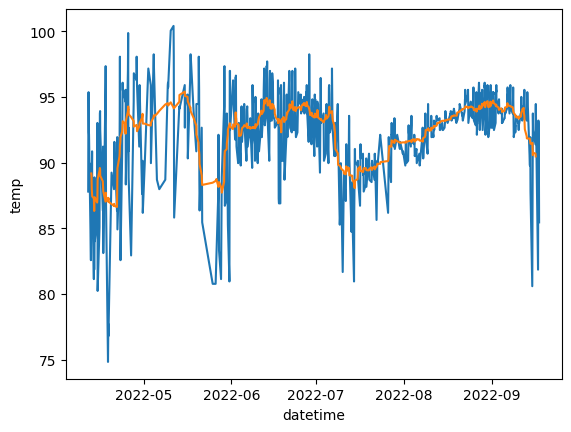

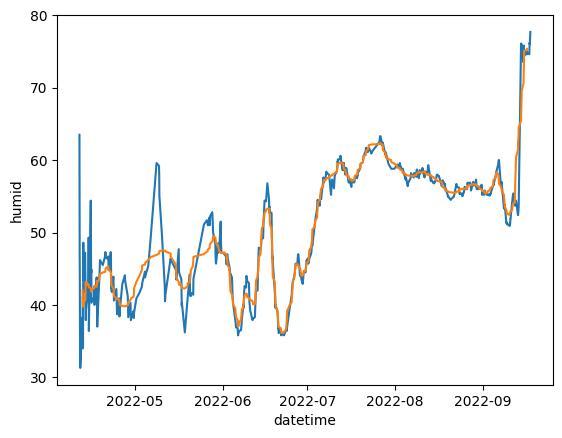

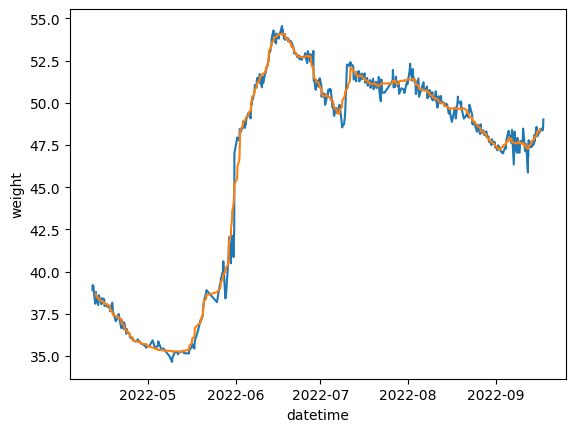

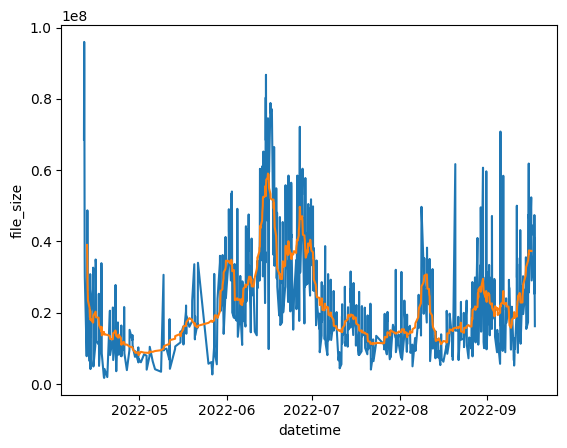

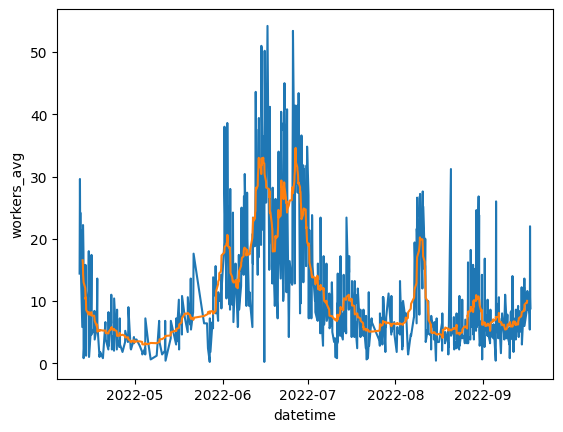

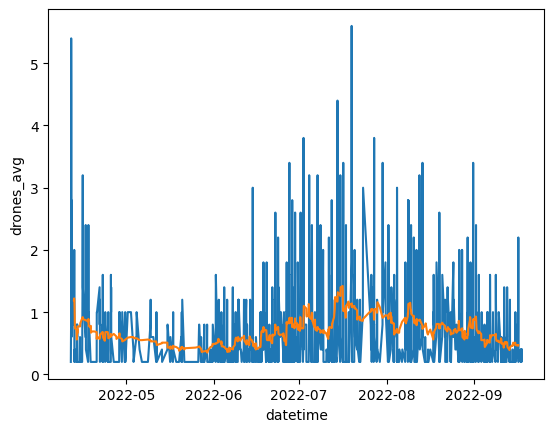

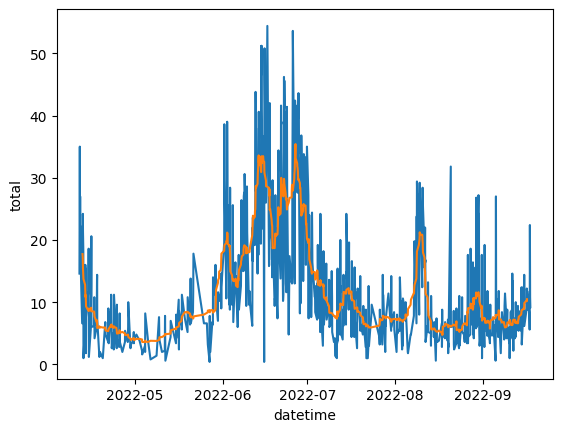

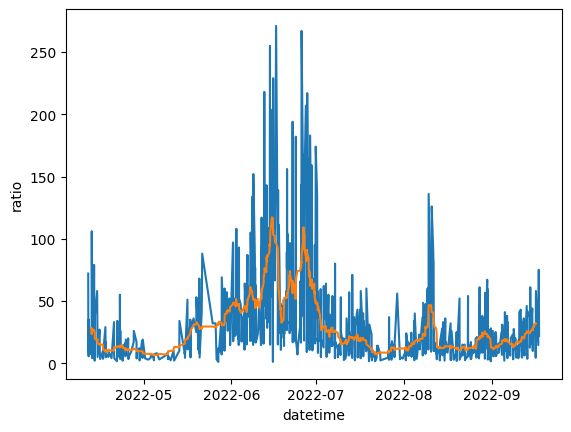

In [231]:
ma = 20
shift = 0 - int(ma / 2)

#add 5ma
df['total_ma'] = df['total'].rolling(ma).mean()
df['total_ma'] = df['total_ma'].shift(shift)

#add 5ma
df['ratio_ma'] = df['ratio'].rolling(ma).mean()
df['ratio_ma'] = df['ratio_ma'].shift(shift)

#add 5ma
df['weight_ma'] = df['weight'].rolling(ma).mean()
df['weight_ma'] = df['weight_ma'].shift(shift)

#add 5ma
df['file_size_ma'] = df['file_size'].rolling(ma).mean()
df['file_size_ma'] = df['file_size_ma'].shift(shift)

#add 5ma
df['temp_ma'] = df['temp'].rolling(ma).mean()
df['temp_ma'] = df['temp_ma'].shift(shift)

#add 5ma
df['humid_ma'] = df['humid'].rolling(ma).mean()
df['humid_ma'] = df['humid_ma'].shift(shift)

#add 5ma
df['workers_avg_ma'] = df['workers_avg'].rolling(ma).mean()
df['workers_avg_ma'] = df['workers_avg_ma'].shift(shift)

#add 5ma
df['drones_avg_ma'] = df['drones_avg'].rolling(ma).mean()
df['drones_avg_ma'] = df['drones_avg_ma'].shift(shift)


#plot temp
sns.lineplot(x="datetime", y="temp", data=df)
sns.lineplot(x="datetime", y="temp_ma", data=df)
plt.show()

#plot humid
sns.lineplot(x="datetime", y="humid", data=df)
sns.lineplot(x="datetime", y="humid_ma", data=df)
plt.show()

#plot weight
sns.lineplot(x="datetime", y="weight", data=df)
sns.lineplot(x="datetime", y="weight_ma", data=df)
plt.show()

#plot file_size
sns.lineplot(x="datetime", y="file_size", data=df)
sns.lineplot(x="datetime", y="file_size_ma", data=df)
plt.show()

#plot workers_avg
sns.lineplot(x="datetime", y="workers_avg", data=df)
sns.lineplot(x="datetime", y="workers_avg_ma", data=df)
plt.show()

#plot drones_avg
sns.lineplot(x="datetime", y="drones_avg", data=df)
sns.lineplot(x="datetime", y="drones_avg_ma", data=df)
plt.show()

#plot total
sns.lineplot(x="datetime", y="total", data=df)
sns.lineplot(x="datetime", y="total_ma", data=df)
plt.show()

#plot ratio
sns.lineplot(x="datetime", y="ratio", data=df)
sns.lineplot(x="datetime", y="ratio_ma", data=df)
plt.show()

In [127]:
#add column to indicate the change in weight
df['weight_change'] = df['weight'].diff()
#get absolute value
df['weight_change'] = df['weight_change'].abs()

#add column to indicate the change in weight
df['workers_avg_change'] = df['workers_avg'].diff()
#get absolute value
df['workers_avg_change'] = df['workers_avg_change'].abs()

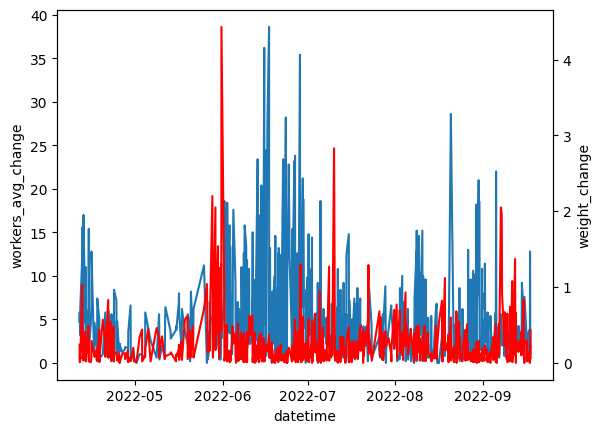

In [129]:
# plot weight and ratio
sns.lineplot(x="datetime", y="workers_avg_change", data=df)

ax2 = plt.twinx()

sns.lineplot(x="datetime", y="weight_change", data=df, ax=ax2, color='r')

plt.show()


In [137]:
#get linear correlation between file size and total 
file_size_corr = round(df[['file_size', 'total']].corr(method='pearson')['total']['file_size']*100,1)
print(f"Total bees are for {file_size_corr}% defined by the file size")

#get linear correlation between weight and total
file_size_corr = round(df[['weight', 'total']].corr(method='pearson')['total']['weight']*100,1)
print(f"Total bees are for {file_size_corr}% defined by the hive weight")

#get linear correlation between temp and total
file_size_corr = round(df[['temp', 'total']].corr(method='pearson')['total']['temp']*100,1)
print(f"Total bees are for {file_size_corr}% defined by the temperature")

#get linear correlation between humid and total
file_size_corr = round(df[['humid', 'total']].corr(method='pearson')['total']['humid']*100,1)
print(f"Total bees are for {file_size_corr}% defined by the humidity")

Aantal bijen kan voor 81.6% verklaard worden door de file size
Aantal bijen kan voor 40.4% verklaard worden door het gewicht
Aantal bijen kan voor 26.5% verklaard worden door de temperatuur
Aantal bijen kan voor -31.1% verklaard worden door de luchtvochtigheid


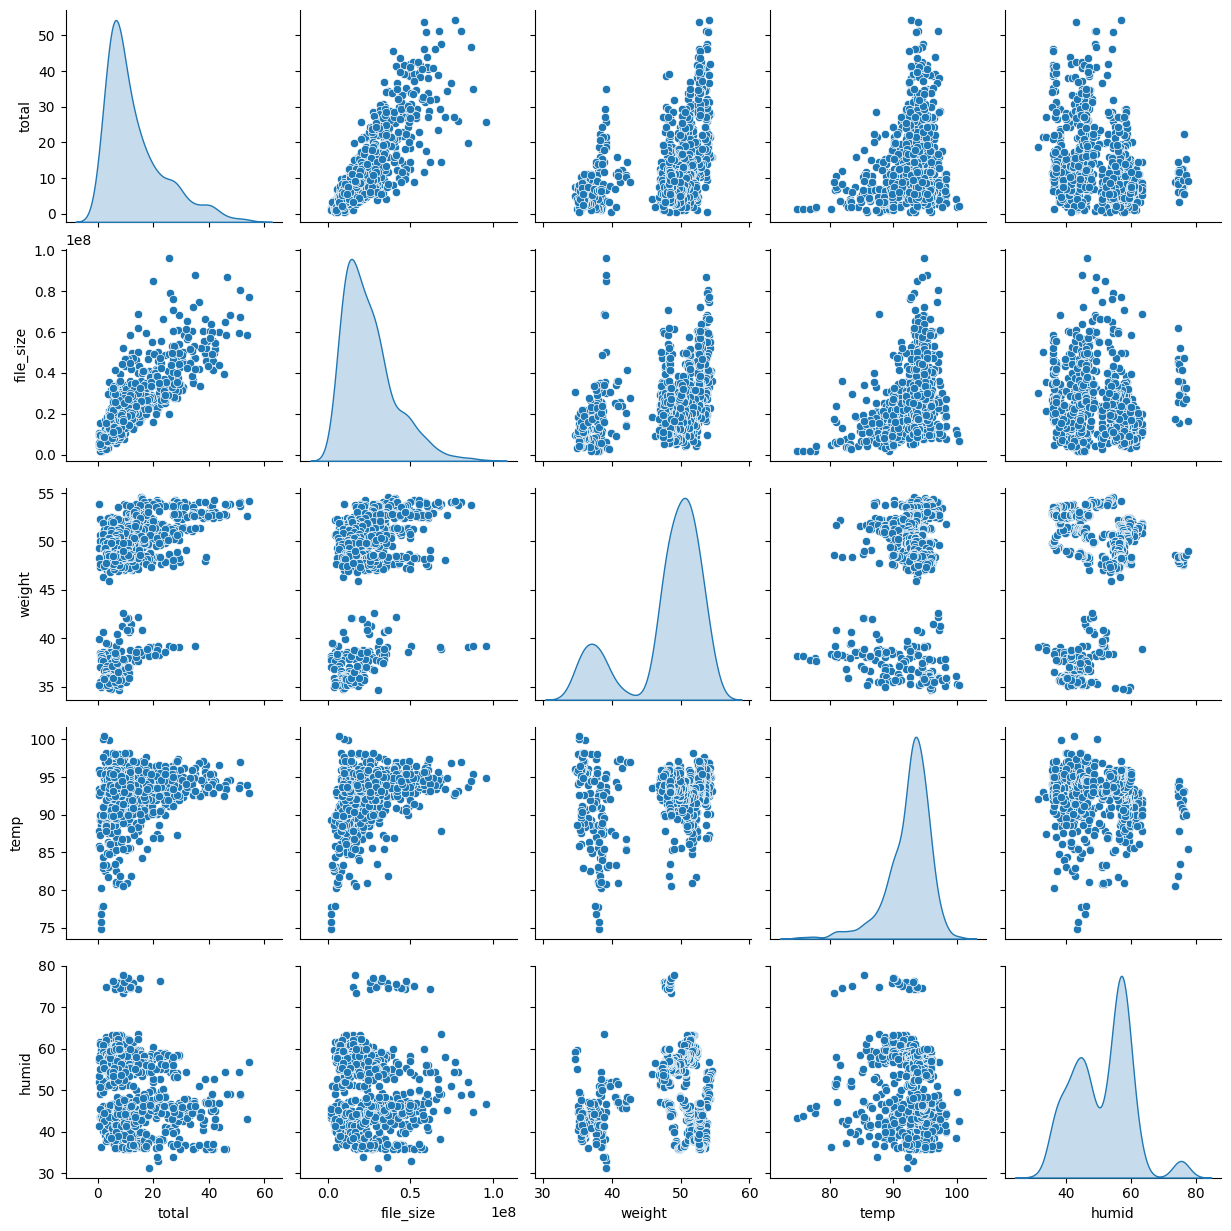

In [138]:
#show pairplot
sns.pairplot(df[['total', 'file_size', 'weight', 'temp', 'humid']], diag_kind='kde')
plt.show()

In [237]:
df2 = df.dropna()
df2['hour_int'] = df2['datetime'].dt.hour
df2.head()

C:\Users\Thomas\AppData\Local\Temp\ipykernel_12060\2738433008.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['hour_int'] = df2['datetime'].dt.hour


In [263]:
#use linear regresssion to predict total_ma

X = df2[['file_size_ma', 'weight_ma', 'temp_ma', 'humid_ma', 'hour_int']]
y = df2['total_ma']

#split data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#apply scaling
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.transform(X_test)

#fit model
model = LinearRegression(fit_intercept=True, n_jobs=1)
model.fit(X_train_ss, y_train)
y_pred = model.predict(X_test_ss)
print(f"R2 score: {round(r2_score(y_test, y_pred)*100,1)}%")
print(f"RMSE: {round(np.sqrt(mean_squared_error(y_test, y_pred)),1)}")
print('Interccept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

R2 score: 94.6%
RMSE: 2.0
Interccept: 
 13.023923611111108
Coefficients: 
 [     5.7995      2.3458    -0.50761     -2.6837     0.25411]


Highest score: 94.7% (standard scaling, sensor data + hour of the day, linear regression)

In [242]:
#pickle this model
import pickle
filename = 'linear_model_ss_hour.pkl'
pickle.dump(model, open(filename, 'wb'))